In [3]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# KDD Cup 98 LTV Prediction

In [4]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-11-23 07:40:54.702481: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 07:40:54.715544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732347654.732023    6505 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732347654.736880    6505 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 07:40:54.753162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
#!pip install --upgrade tensorflow-probability

In [6]:
#!pip install --upgrade tf-keras

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kdd_cup_98/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kdd_cup_98/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [7]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Sequence

# install and import ltv
#!pip install -q git+https://github.com/google/lifetime_value
!pip install -q git+https://github.com/seyedrezamirkhani/lifetime_value
import lifetime_value as ltv

from tensorflow.keras.utils import  plot_model

In [8]:
tfd = tfp.distributions
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')

## Configs

In [9]:
MODEL = 'dnn'
# LOSS = 'ziln' # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
LOSS = 'mse' # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
LEARNING_RATE = 0.001  # @param { isTemplate: true}
VERSION = 0 # @param { isTemplate: true, type: 'integer'}
OUTPUT_CSV_FOLDER = './tmp/lifetime-value/kdd_cup_98/result' # @param { isTemplate: true, type: 'string'}

## Load data

Download kdd_cup_98 data to /tmp/lifetime-value/kdd_cup_98

%%bash
mkdir -p tmp/lifetime-value/kdd_cup_98
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98lrn.zip -P tmp/lifetime-value/kdd_cup_98/
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98val.zip -P tmp/lifetime-value/kdd_cup_98/
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/valtargt.txt -P tmp/lifetime-value/kdd_cup_98/
cd tmp/lifetime-value/kdd_cup_98/
unzip cup98lrn.zip
unzip cup98val.zip

In [10]:
df_train = pd.read_csv('tmp/lifetime-value/kdd_cup_98/cup98LRN.txt')
num_train = df_train.shape[0]
df_eval = pd.read_csv('tmp/lifetime-value/kdd_cup_98/cup98VAL.txt')
df_eval_target = pd.read_csv('tmp/lifetime-value/kdd_cup_98/valtargt.txt')
df_eval = df_eval.merge(df_eval_target, on='CONTROLN')

/tmp/ipykernel_6088/2737608801.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('tmp/lifetime-value/kdd_cup_98/cup98LRN.txt')
/tmp/ipykernel_6088/2737608801.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eval = pd.read_csv('tmp/lifetime-value/kdd_cup_98/cup98VAL.txt')


In [11]:
df = pd.concat([df_train, df_eval], axis=0, sort=True)

## Label distribution

In [12]:
y = df['TARGET_D'][:num_train]

In [13]:
def plot_hist_log_scale(y):
  max_val = y.max() + 1. 
  ax = pd.Series(y).hist(
      figsize=(8, 5), bins = 10 ** np.linspace(0., np.log10(max_val), 20))

  plt.xlabel('Donation ($)')
  plt.ylabel('Count')
  # plt.title('Histogram of LTV')
  plt.xticks(rotation='horizontal')
  plt.legend(loc='upper left')
  ax.set_xscale('log')
  ax.grid(False)
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.show()

  fig = ax.get_figure()
  output_file = tf.io.gfile.GFile(
          'tmp/lifetime-value/kdd_cup_98/histogram_kdd98_log_scale.pdf',
          'wb')
  fig.savefig(output_file, bbox_inches='tight', format='pdf')

/tmp/ipykernel_6088/2558387972.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


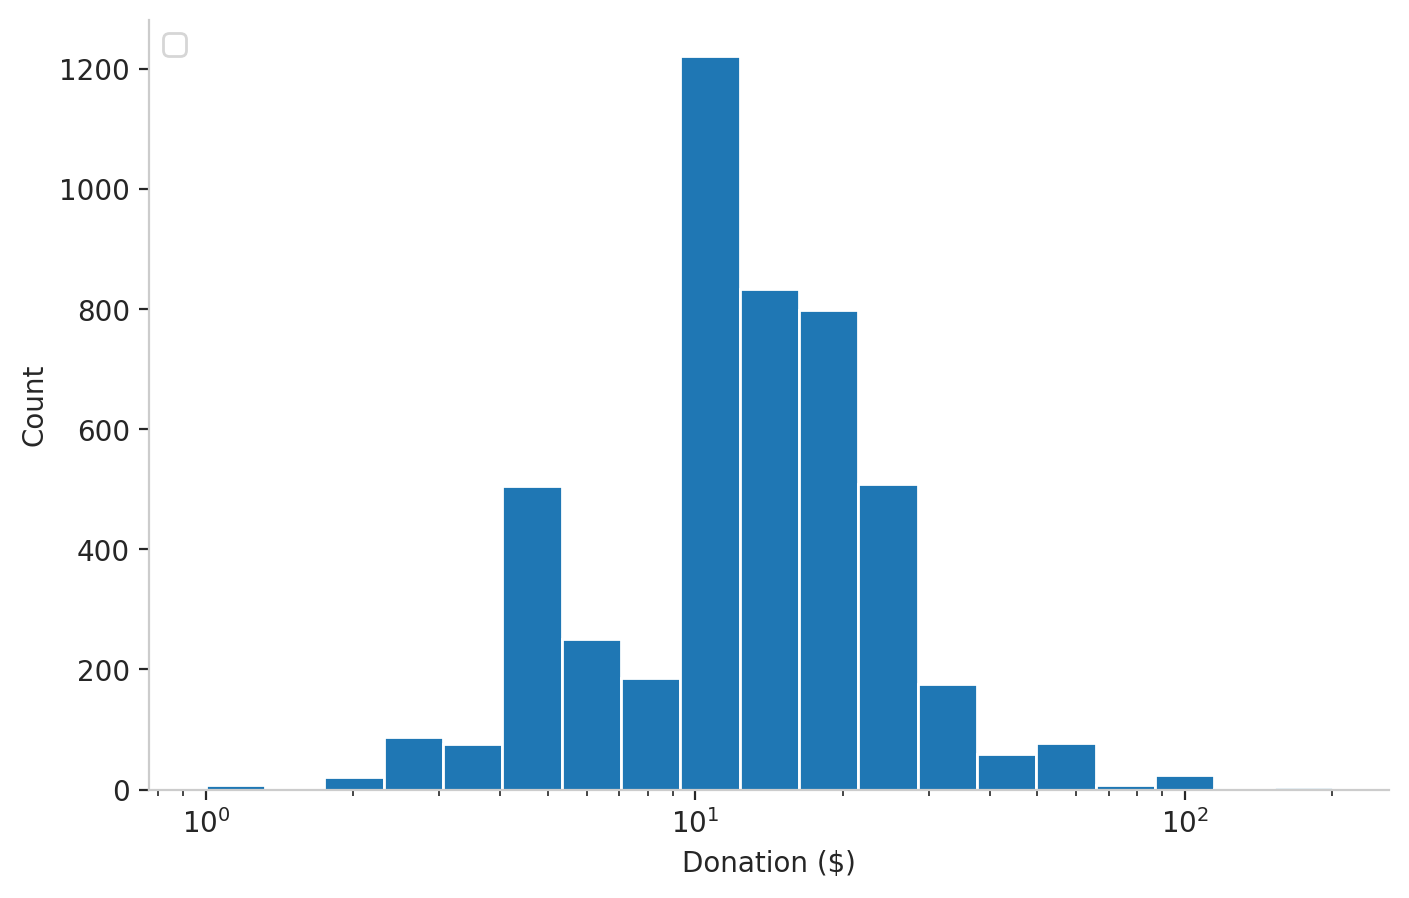

In [14]:
plot_hist_log_scale(y[y>0])

## Preprocess features

### Vocab

In [15]:
VOCAB_FEATURES = [
    'ODATEDW',  # date of donor's first gift (YYMM)
    'OSOURCE',  # donor acquisition mailing list
    'TCODE',    # donor title code
    'STATE',
    'ZIP',
    'DOMAIN',   # urbanicity level and socio-economic status of the neighborhood
    'CLUSTER',  # socio-economic status
    'GENDER',
    'MAXADATE', # date of the most recent promotion received
    'MINRDATE',
    'LASTDATE',
    'FISTDATE',
    'RFA_2A',
]

In [16]:
df['ODATEDW'] = df['ODATEDW'].astype('str')
df['TCODE'] = df['TCODE'].apply(
    lambda x: '{:03d}'.format(x // 1000 if x > 1000 else x))
df['ZIP'] = df['ZIP'].str.slice(0, 5)
df['MAXADATE'] = df['MAXADATE'].astype('str')
df['MINRDATE'] = df['MINRDATE'].astype('str')
df['LASTDATE'] = df['LASTDATE'].astype('str')
df['FISTDATE'] = df['FISTDATE'].astype('str')

In [17]:
def label_encoding(y, frequency_threshold=100):
  value_counts = pd.value_counts(y)
  categories = value_counts[
      value_counts >= frequency_threshold].index.to_numpy()
  # 0 indicates the unknown category.
  return pd.Categorical(y, categories=categories).codes + 1

In [18]:
for key in VOCAB_FEATURES:
  df[key] = label_encoding(df[key])

/tmp/ipykernel_6088/102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(y)
/tmp/ipykernel_6088/102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(y)
/tmp/ipykernel_6088/102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(y)
/tmp/ipykernel_6088/102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(y)
/tmp/ipykernel_6088/102338538.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_cou

### Indicator

In [19]:
MAIL_ORDER_RESPONSES = [
    'MBCRAFT',
    'MBGARDEN',
    'MBBOOKS',
    'MBCOLECT',
    'MAGFAML',
    'MAGFEM',
    'MAGMALE',
    'PUBGARDN',
    'PUBCULIN',
    'PUBHLTH',
    'PUBDOITY',
    'PUBNEWFN',
    'PUBPHOTO',
    'PUBOPP',
    'RFA_2F',
]

In [20]:
INDICATOR_FEATURES = [
    'AGE',  # age decile, 0 indicates unknown
    'NUMCHLD',
    'INCOME',
    'WEALTH1',
    'HIT',
] + MAIL_ORDER_RESPONSES

In [21]:
df['AGE'] = pd.qcut(df['AGE'].values, 10).codes + 1
df['NUMCHLD'] = df['NUMCHLD'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['INCOME'] = df['INCOME'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['WEALTH1'] = df['WEALTH1'].apply(lambda x: 0 if np.isnan(x) else int(x) + 1)
df['HIT'] = pd.qcut(df['HIT'].values, q=50, duplicates='drop').codes

for col in MAIL_ORDER_RESPONSES:
  df[col] = pd.qcut(df[col].values, q=20, duplicates='drop').codes + 1

### Numeric

In [22]:
NUMERIC_FEATURES = [
    # binary
    'MAILCODE',  # bad address
    'NOEXCH',    # do not exchange
    'RECINHSE',  # donor has given to PVA's in house program
    'RECP3',     # donor has given to PVA's P3 program
    'RECPGVG',   # planned giving record
    'RECSWEEP',  # sweepstakes record
    'HOMEOWNR',  # home owner
    'CHILD03',
    'CHILD07',
    'CHILD12',
    'CHILD18',

    # continuous
    'CARDPROM',
    'NUMPROM',
    'CARDPM12',
    'NUMPRM12',
    'RAMNTALL',
    'NGIFTALL',
    'MINRAMNT',
    'MAXRAMNT',
    'LASTGIFT',
    'AVGGIFT',
]

In [23]:
df['MAILCODE'] = (df['MAILCODE'] == 'B').astype('float32')
df['PVASTATE'] = df['PVASTATE'].isin(['P', 'E']).astype('float32')
df['NOEXCH'] = df['NOEXCH'].isin(['X', '1']).astype('float32')
df['RECINHSE'] = (df['RECINHSE'] == 'X').astype('float32')
df['RECP3'] = (df['RECP3'] == 'X').astype('float32')
df['RECPGVG'] = (df['RECPGVG'] == 'X').astype('float32')
df['RECSWEEP'] = (df['RECSWEEP'] == 'X').astype('float32')
df['HOMEOWNR'] = (df['HOMEOWNR'] == 'H').astype('float32')
df['CHILD03'] = df['CHILD03'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD07'] = df['CHILD07'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD12'] = df['CHILD12'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD18'] = df['CHILD18'].isin(['M', 'F', 'B']).astype('float32')

df['CARDPROM'] = df['CARDPROM'] / 100
df['NUMPROM'] = df['NUMPROM'] / 100
df['CARDPM12'] = df['CARDPM12'] / 100
df['NUMPRM12'] = df['NUMPRM12'] / 100
df['RAMNTALL'] = np.log1p(df['RAMNTALL'])
df['NGIFTALL'] = np.log1p(df['NGIFTALL'])
df['MINRAMNT'] = np.log1p(df['MINRAMNT'])
df['MAXRAMNT'] = np.log1p(df['MAXRAMNT'])
df['LASTGIFT'] = np.log1p(df['LASTGIFT'])
df['AVGGIFT'] = np.log1p(df['AVGGIFT'])

### All

In [24]:
CATEGORICAL_FEATURES = VOCAB_FEATURES + INDICATOR_FEATURES
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Train/eval split

In [25]:
def dnn_split(df):
  df_train = df.iloc[:num_train]
  df_eval = df.iloc[num_train:]

  def feature_dict(df):
    features = dict()
    for k, v in dict(df[NUMERIC_FEATURES]).items():
        features[k] = v.values    
      
    #for k, v in dict(df[CATEGORICAL_FEATURES]).items():
    #    features[k] = v.values    
    return features

  x_train, y_train = feature_dict(df_train), df_train['TARGET_D'].astype(
      'float32').values
  x_eval, y_eval = feature_dict(df_eval), df_eval['TARGET_D'].astype(
      'float32').values
#  x_train, y_train = pd.DataFrame.from_dict(feature_dict(df_train)), df_train['TARGET_D'].astype(
#      'float32').values
#  x_eval, y_eval = pd.DataFrame.from_dict(feature_dict(df_eval)), df_eval['TARGET_D'].astype(
#      'float32').values


  return x_train, x_eval, y_train, y_eval

## Model

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate

def embedding_dim(x):
    """Calculate embedding dimension based on the number of unique categories."""
    return int(x**0.25) + 1

def create_model(output_units, df):
    """
    Creates a Keras model with specified numerical and categorical features.
    
    Parameters:
    - output_units (int): Number of nodes in the final output layer.
    - df (pd.DataFrame): Dataframe containing the features to calculate input dimensions.
    
    Returns:
    - model (keras.Model): Compiled Keras model.
    """
    # List of numerical input features
    numeric_features = [
        'MAILCODE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'HOMEOWNR',
        'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'CARDPROM', 'NUMPROM', 'CARDPM12',
        'NUMPRM12', 'RAMNTALL', 'NGIFTALL', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'AVGGIFT'
    ]

    # List of categorical input features
    categorical_features = [
        'ODATEDW', 'OSOURCE', 'TCODE', 'STATE', 'ZIP', 'DOMAIN', 'CLUSTER', 'GENDER',
        'MAXADATE', 'MINRDATE', 'LASTDATE', 'FISTDATE', 'RFA_2A', 'AGE', 'NUMCHLD', 'INCOME',
        'WEALTH1', 'HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML',
        'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN',
        'PUBPHOTO', 'PUBOPP', 'RFA_2F'
    ]

    # Create inputs for numerical features
    numeric_inputs = [Input(shape=(1,), name=feature, dtype=np.float32) for feature in numeric_features]
    #numeric_inputs = [Input(shape=(1,), name=feature, dtype=df.dtypes[feature].type) for feature in numeric_features]    

    # Create inputs and embeddings for categorical features
#    categorical_inputs = []
#    categorical_embeddings = []

#    for feature in categorical_features:
#        if feature in df.columns:
#            cat_input = Input(shape=(1,), name=feature)
#            input_dim = df[feature].max() + 1  # Assumes 0-based categories
#            output_dim = embedding_dim(input_dim)
#            embedding = Embedding(input_dim=input_dim, output_dim=output_dim, name=f'{feature}_EMBEDDING')(cat_input)
#            embedding_flat = Flatten()(embedding)

#            categorical_inputs.append(cat_input)
#            categorical_embeddings.append(embedding_flat)
#        else:
#            print(f"Warning: {feature} not found in dataframe columns.")

    # Concatenate all inputs
#    concatenated = Concatenate()(numeric_inputs + categorical_embeddings)
    concatenated = Concatenate()(numeric_inputs)

    # Dense Layers
    dense_1 = Dense(128, activation='relu')(concatenated)
    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_3 = Dense(64, activation='relu')(dense_2)
    dense_4 = Dense(64, activation='relu')(dense_3)
    output = Dense(output_units, activation='linear')(dense_4)

    # Model
    #model = Model(inputs=numeric_inputs + categorical_inputs, outputs=output)
    model = Model(inputs=numeric_inputs, outputs=output)

    # Compile the model
    # model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


## Loss

In [27]:
if LOSS == 'mse':
  loss = tf.keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [28]:
x_train, x_eval, y_train, y_eval = dnn_split(df)
# model = dnn_model(output_units)


In [29]:
model = create_model(output_units, df)

I0000 00:00:1732347669.950018    6088 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22128 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [30]:
x_train

{'MAILCODE': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'NOEXCH': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'RECINHSE': array([0., 0., 0., ..., 0., 1., 1.], dtype=float32),
 'RECP3': array([0., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'RECPGVG': array([0., 0., 0., ..., 0., 0., 1.], dtype=float32),
 'RECSWEEP': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'HOMEOWNR': array([0., 1., 0., ..., 0., 1., 0.], dtype=float32),
 'CHILD03': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'CHILD07': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'CHILD12': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'CHILD18': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'CARDPROM': array([0.27, 0.12, 0.26, ..., 0.14, 0.36, 0.32]),
 'NUMPROM': array([0.74, 0.32, 0.63, ..., 0.33, 1.27, 1.39]),
 'CARDPM12': array([0.06, 0.06, 0.06, ..., 0.07, 0.09, 0.06]),
 'NUMPRM12': array([0.14, 0.13, 0.14, ..., 0.17, 0.31, 0.35]),
 'RAMNTALL': array([5.48479693, 3

In [31]:
#x_train.dtypes['MAILCODE'].type

In [32]:
#model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE), loss=loss, run_eagerly=True)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE), loss=loss)

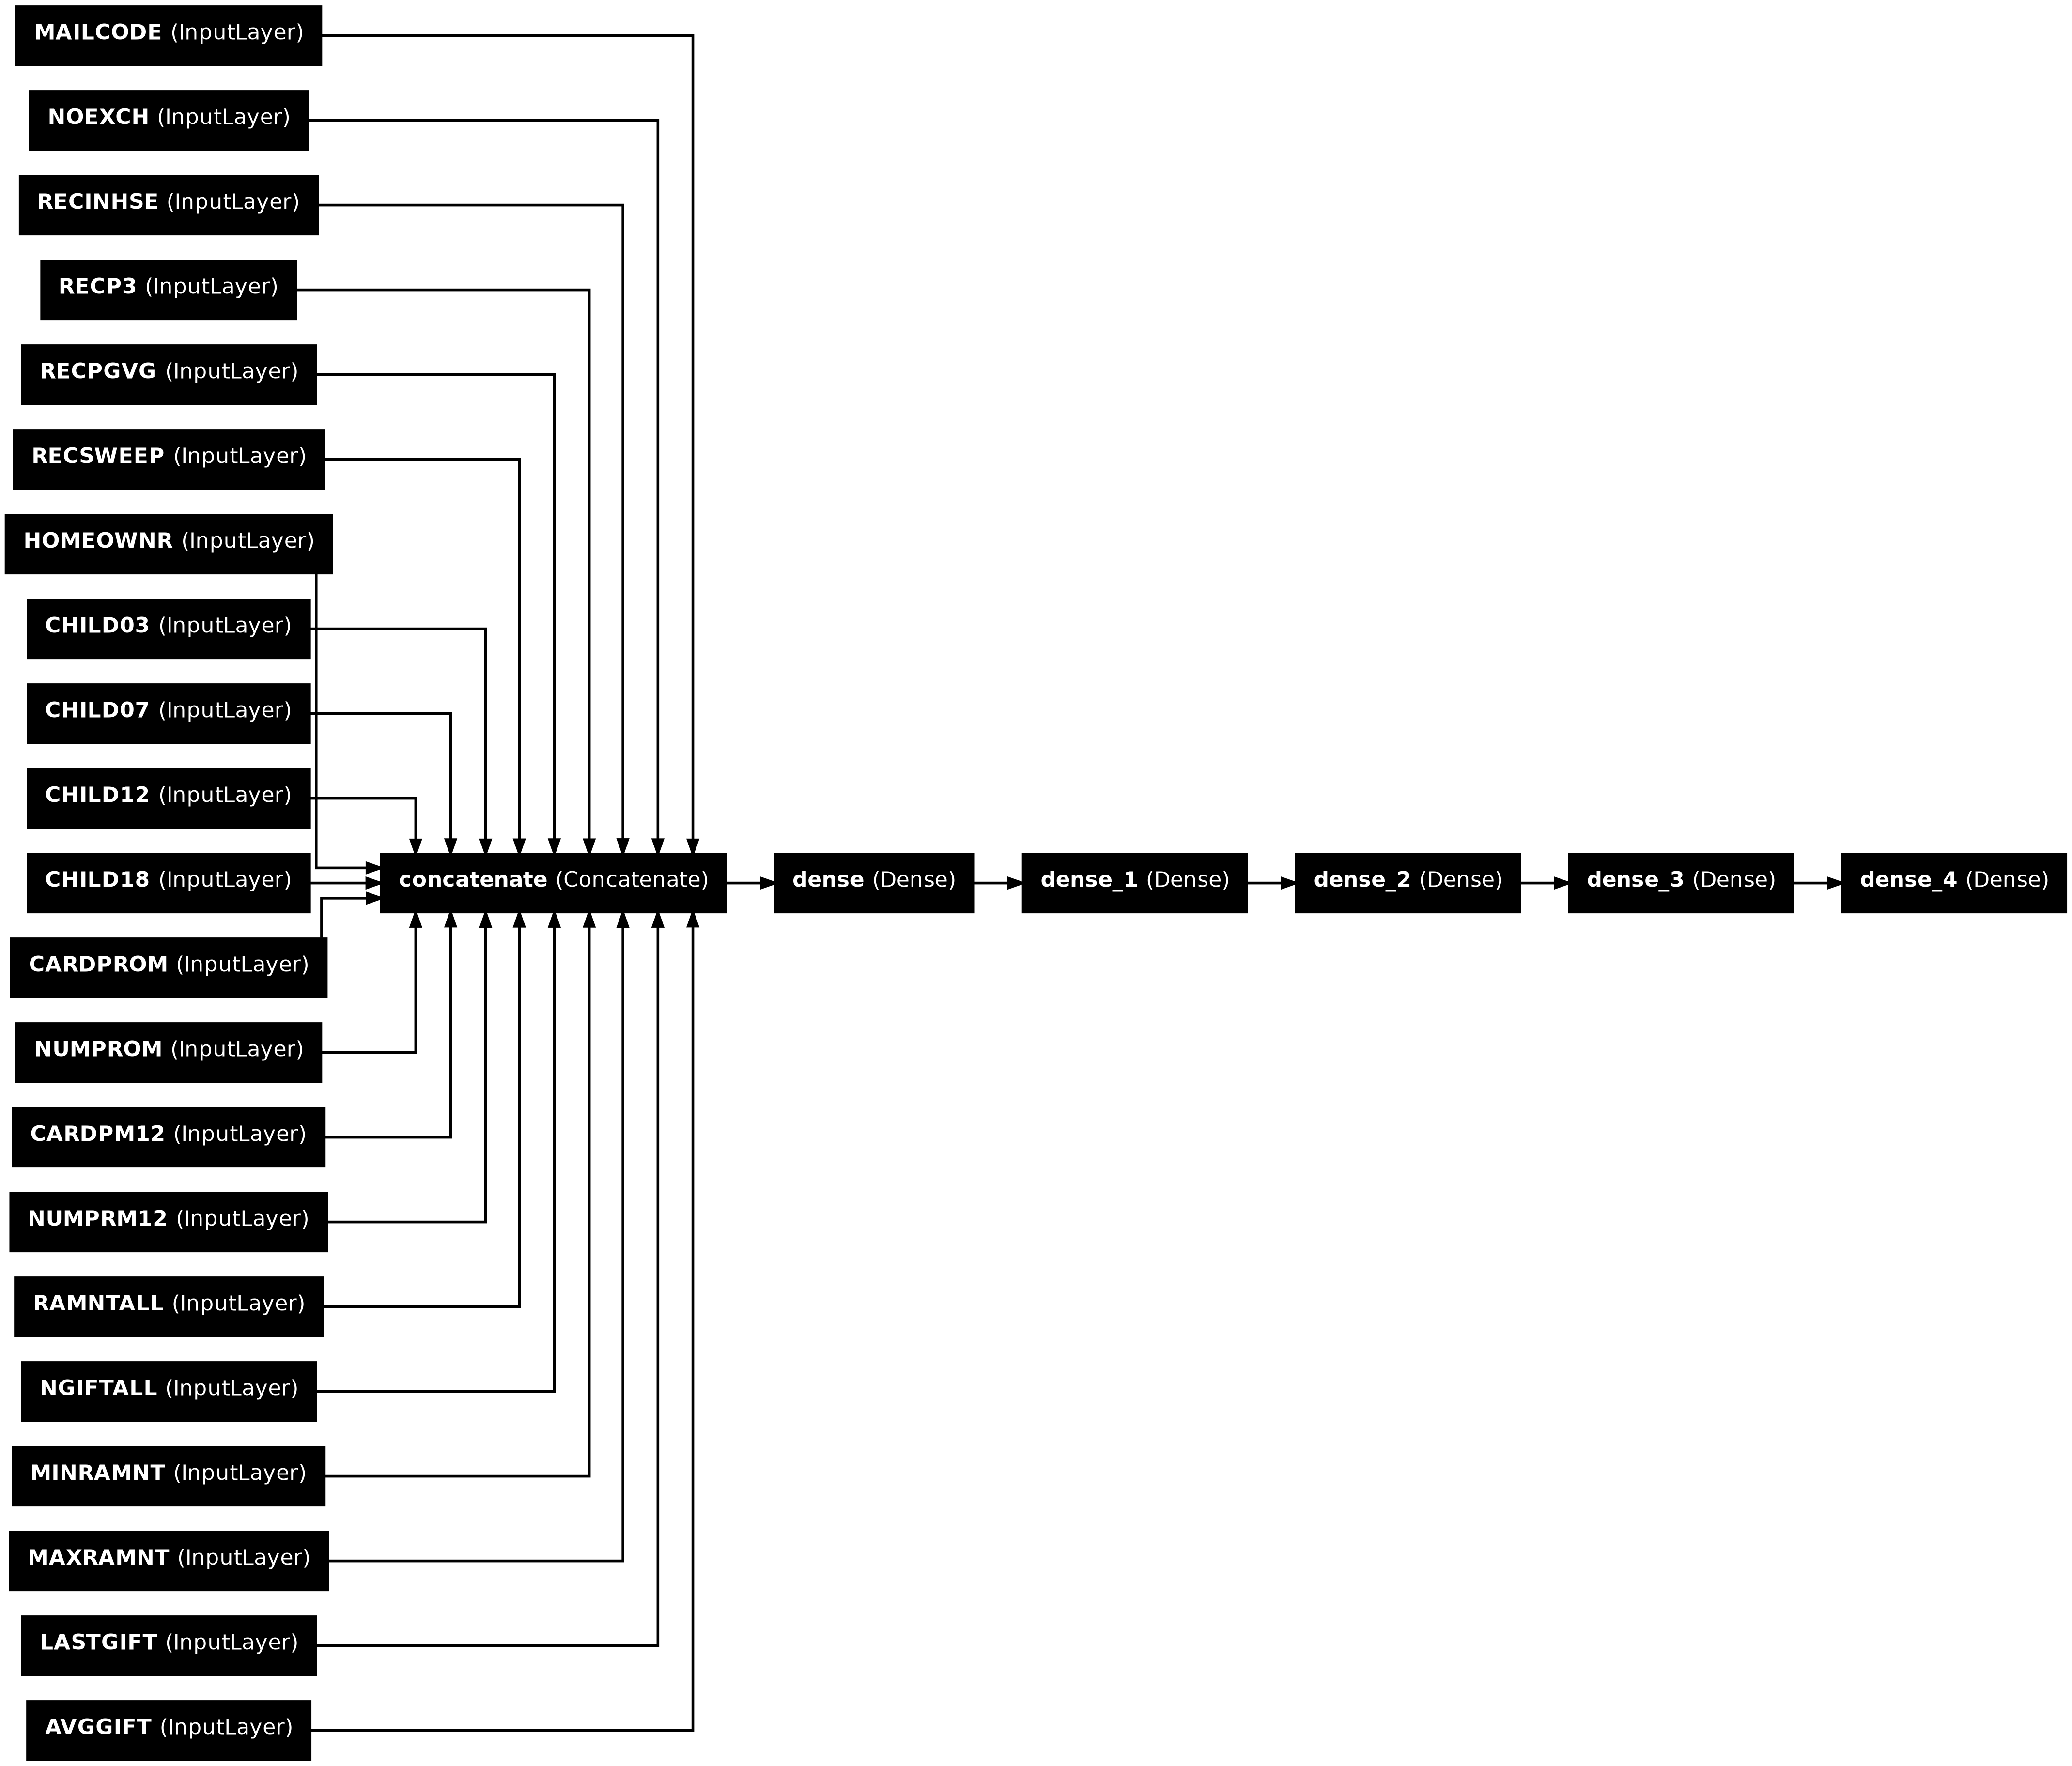

In [33]:
# Plot the model
plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=False, rankdir='LR')

In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ MAILCODE            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOEXCH (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RECINHSE            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RECP3 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RECPGVG             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RECSWEEP            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HOMEOWNR            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CHILD03             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CHILD07             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CHILD12             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CHILD18             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CARDPROM            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NUMPROM             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CARDPM12            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NUMPRM12            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RAMNTALL            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NGIFTALL            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 31,809 (124.25 KB)

 Trainable params: 31,809 (124.25 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
#x_train.head().to_csv('x_train.csv', index=False)

## Train

In [36]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [37]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=2048,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Epoch 1/200


/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['MAILCODE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'HOMEOWNR', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'CARDPROM', 'NUMPROM', 'CARDPM12', 'NUMPRM12', 'RAMNTALL', 'NGIFTALL', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'AVGGIFT']. Received: the structure of inputs={'MAILCODE': '*', 'NOEXCH': '*', 'RECINHSE': '*', 'RECP3': '*', 'RECPGVG': '*', 'RECSWEEP': '*', 'HOMEOWNR': '*', 'CHILD03': '*', 'CHILD07': '*', 'CHILD12': '*', 'CHILD18': '*', 'CARDPROM': '*', 'NUMPROM': '*', 'CARDPM12': '*', 'NUMPRM12': '*', 'RAMNTALL': '*', 'NGIFTALL': '*', 'MINRAMNT': '*', 'MAXRAMNT': '*', 'LASTGIFT': '*', 'AVGGIFT': '*'}
  warnings.warn(
I0000 00:00:1732347693.523292    6714 service.cc:148] XLA service 0x7dc6d0003e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:

47/47 - 13s - 269ms/step - loss: 19.6240 - val_loss: 22.3031 - learning_rate: 1.0000e-03
Epoch 2/200
47/47 - 0s - 6ms/step - loss: 19.5697 - val_loss: 22.2890 - learning_rate: 1.0000e-03
Epoch 3/200
47/47 - 0s - 5ms/step - loss: 19.5618 - val_loss: 22.2636 - learning_rate: 1.0000e-03
Epoch 4/200
47/47 - 0s - 5ms/step - loss: 19.5573 - val_loss: 22.2632 - learning_rate: 1.0000e-03
Epoch 5/200
47/47 - 0s - 5ms/step - loss: 19.5535 - val_loss: 22.2481 - learning_rate: 1.0000e-03
Epoch 6/200
47/47 - 0s - 6ms/step - loss: 19.5431 - val_loss: 22.2405 - learning_rate: 1.0000e-03
Epoch 7/200
47/47 - 0s - 5ms/step - loss: 19.5372 - val_loss: 22.2739 - learning_rate: 1.0000e-03
Epoch 8/200
47/47 - 0s - 6ms/step - loss: 19.5403 - val_loss: 22.2223 - learning_rate: 1.0000e-03
Epoch 9/200
47/47 - 0s - 5ms/step - loss: 19.5315 - val_loss: 22.2255 - learning_rate: 1.0000e-03
Epoch 10/200
47/47 - 0s - 5ms/step - loss: 19.5315 - val_loss: 22.2106 - learning_rate: 1.0000e-03
Epoch 11/200
47/47 - 0s - 5m

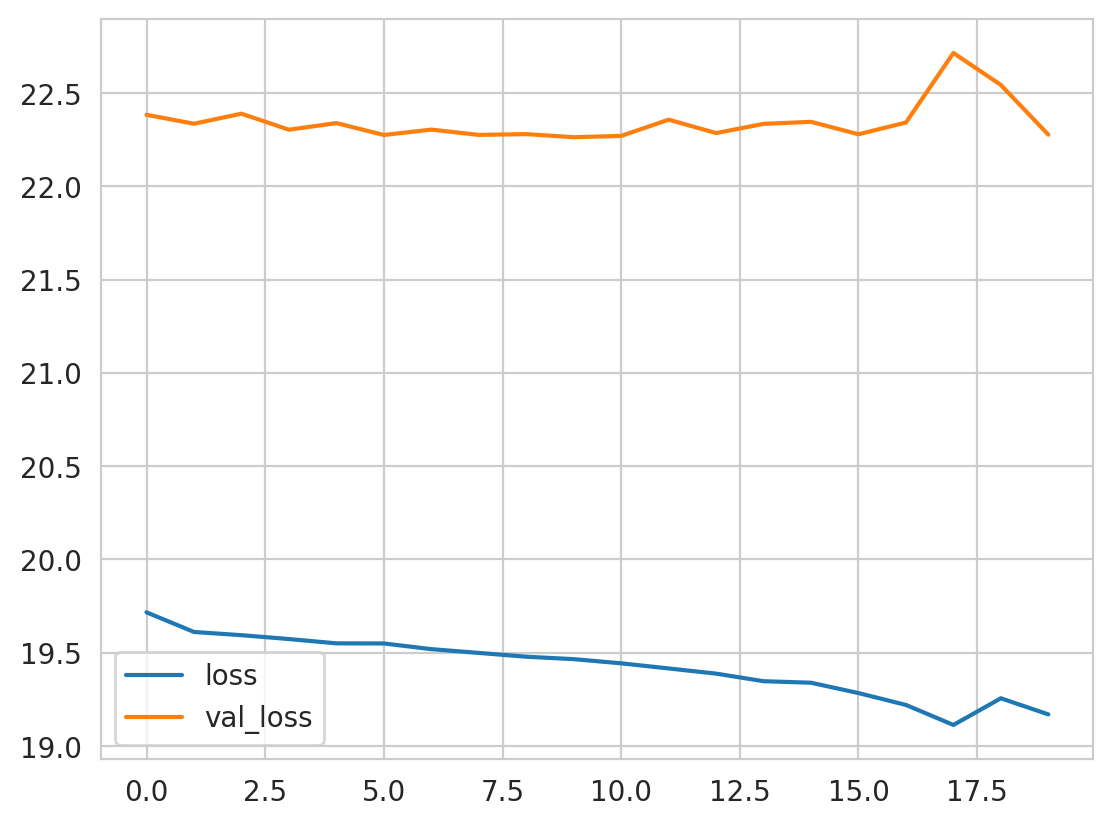

In [35]:
pd.DataFrame(history)[['loss', 'val_loss']].plot();

## Eval

In [40]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

2024-11-23 07:42:02.527620: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_82', 24 bytes spill stores, 24 bytes spill loads

2024-11-23 07:42:02.625387: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_89', 24 bytes spill stores, 24 bytes spill loads



95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


### Total Profit

In [41]:
unit_costs = [0.4, 0.5, 0.6, 0.68, 0.7, 0.8, 0.9, 1.0]

In [42]:
num_mailed = [np.sum(y_pred > v) for v in unit_costs]
num_mailed

[np.int64(95729),
 np.int64(93071),
 np.int64(82870),
 np.int64(66260),
 np.int64(62046),
 np.int64(38416),
 np.int64(22381),
 np.int64(13264)]

In [43]:
baseline_total_profit = np.sum(y_eval - 0.68)
baseline_total_profit

np.float32(10560.074)

In [44]:
total_profits = [np.sum(y_eval[y_pred > v] - v) for v in unit_costs]
total_profits

[np.float32(37531.035),
 np.float32(27918.64),
 np.float32(19801.82),
 np.float32(14018.6455),
 np.float32(12957.753),
 np.float32(8783.648),
 np.float32(5861.0513),
 np.float32(4735.45)]

### Gini Coefficient

In [45]:
x_eval_numeric_df = pd.DataFrame()
for c in NUMERIC_FEATURES:
    x_eval_numeric_df[c] = x_eval[c]
#x_eval_numeric = x_eval_numeric_df[NUMERIC_FEATURES].values
#x_eval_numeric = x_eval_numeric_df.iloc[:, list(range(19))].values
x_eval_numeric = x_eval_numeric_df.iloc[:, list(range(19))].values.tolist()


In [46]:
x_eval_numeric_df.iloc[:, list(range(19))].values.shape

(96367, 19)

In [47]:
x_eval_numeric

[[0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.19,
  0.42,
  0.07,
  0.14,
  4.532599493153256,
  1.9459101490553132,
  1.3862943611198906,
  3.4011973816621555],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.09,
  0.21,
  0.04,
  0.1,
  3.4339872044851463,
  1.0986122886681098,
  2.3978952727983707,
  3.044522437723423],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.24,
  0.61,
  0.06,
  0.13,
  5.3981627015177525,
  2.302585092994046,
  2.3978952727983707,
  3.58351893845611],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.14,
  0.32,
  0.06,
  0.12,
  3.7376696182833684,
  1.3862943611198906,
  1.791759469228055,
  2.995732273553991],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.17,
  0.47,
  0.05,
  0.12,
  3.8501476017100584,
  2.1972245773362196,
  1.3862943611198906,
  2.3978952727983707],
 [0.0,
  0.0,
  0.

In [48]:
x_eval_numeric[:2]

[[0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.19,
  0.42,
  0.07,
  0.14,
  4.532599493153256,
  1.9459101490553132,
  1.3862943611198906,
  3.4011973816621555],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.09,
  0.21,
  0.04,
  0.1,
  3.4339872044851463,
  1.0986122886681098,
  2.3978952727983707,
  3.044522437723423]]

In [49]:
y_eval.shape

(96367,)

In [50]:
y_eval[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [51]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, x_eval_numeric),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [52]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

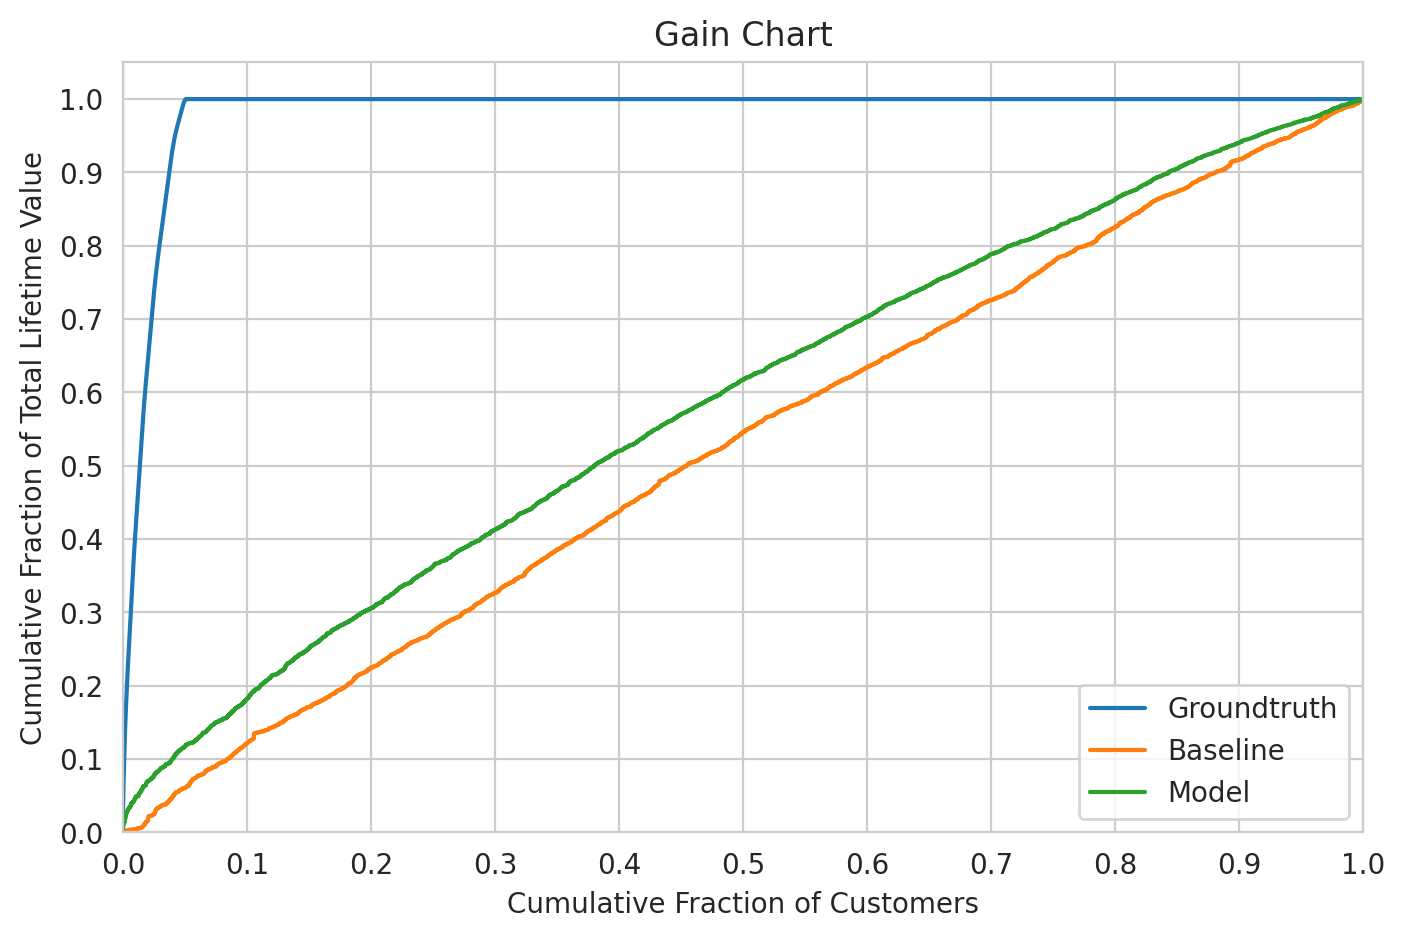

In [53]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='lower right')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart');

In [54]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/lifetime_value/metrics.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized = raw / raw[0]


,raw,normalized
lorenz,0.967057,1.000000
baseline,0.051761,0.053524
model,0.172137,0.178000


### Calibration

In [55]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/lifetime_value/metrics.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('decile').apply(_aggregate_fn)


,label_mean,pred_mean,normalized_rmse,normalized_mae,decile_mape
decile,,,,,
0,0.469493,0.497359,5.131469,1.941437,0.059354
1,0.611634,0.602417,5.141378,1.879224,0.015071
2,0.590117,0.650377,4.981444,1.991724,0.102114
3,0.672702,0.696233,4.770789,1.921851,0.034980
4,0.678082,0.736423,4.894865,1.979696,0.086038
5,0.765826,0.776176,4.685062,1.905211,0.013515
6,0.849227,0.824135,5.093717,1.874986,0.029547
7,0.843192,0.887534,5.159848,1.954071,0.052588
8,0.976497,0.986906,5.418851,1.914941,0.010660


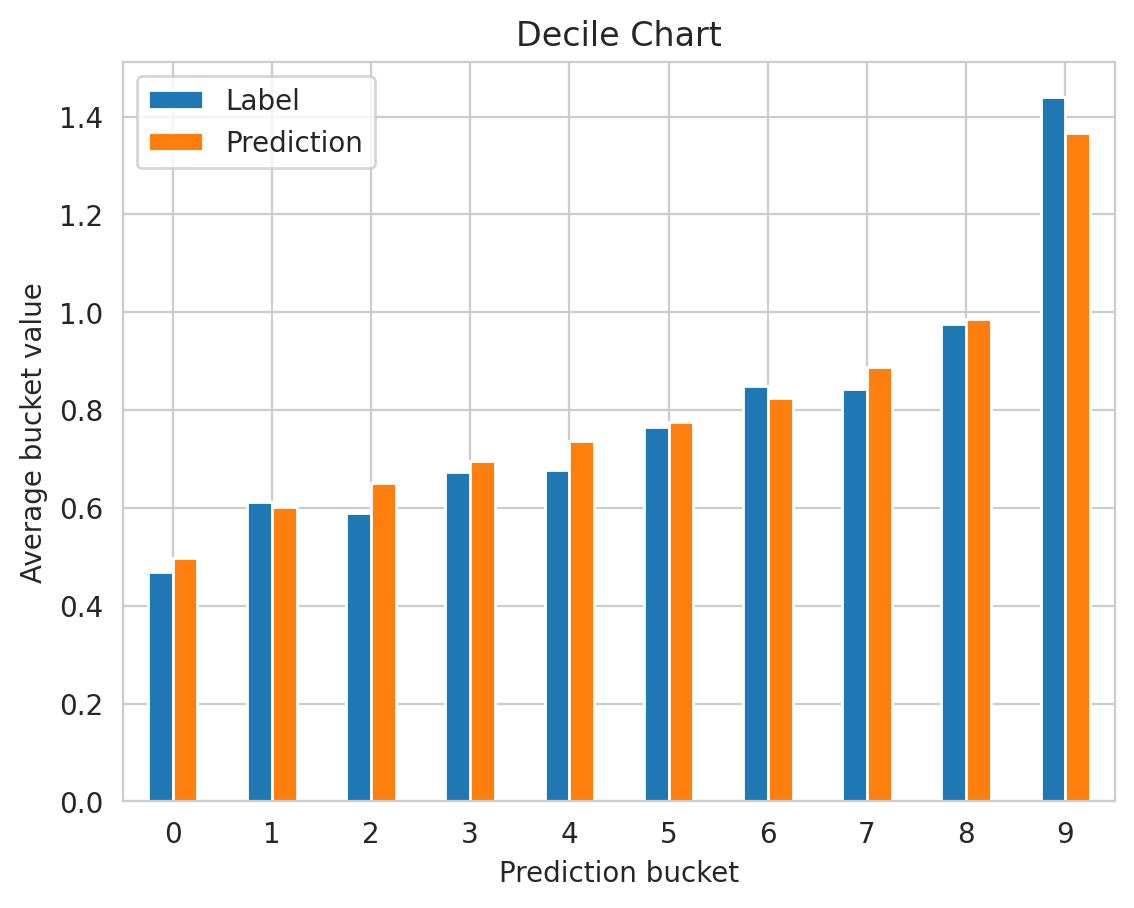

In [56]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left');

### Rank Correlation

In [57]:
def spearmanr(
    x1: Sequence[float],
    x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

np.float64(-0.009036147606360186)

### All metrics together

In [58]:
df_metrics = pd.DataFrame({
    'model': MODEL,
    'loss_function': LOSS,
    'train_loss': history['loss'][-1],
    'eval_loss': history['val_loss'][-1],
    'label_positive': np.mean(y_eval > 0),
    'label_mean': y_eval.mean(),
    'pred_mean': y_pred.mean(),
    'decile_mape': df_decile['decile_mape'].mean(),
    'baseline_gini': gini['normalized'][1],
    'gini': gini['normalized'][2],
    'spearman_corr': spearman_corr,
}, index=[VERSION])

/tmp/ipykernel_6088/3720388555.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'baseline_gini': gini['normalized'][1],
/tmp/ipykernel_6088/3720388555.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'gini': gini['normalized'][2],


In [59]:
for unit_cost, total_profit in zip(unit_costs, total_profits):
  df_metrics['total_profit_{:02d}'.format(int(unit_cost * 100))] = total_profit

In [60]:
df_metrics.T

,0
model,dnn
loss_function,mse
train_loss,19.322678
eval_loss,22.139894
label_positive,0.050567
label_mean,0.789582
pred_mean,0.80237
decile_mape,0.045453
baseline_gini,0.053524
gini,0.178


## Save

In [ ]:
output_path = OUTPUT_CSV_FOLDER

In [ ]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [ ]:
output_file = os.path.join(output_path, '{}_regression_{}_{}.csv'.format(MODEL, LOSS, VERSION))

In [ ]:
df_metrics.to_csv(output_file, index=False)